## Use MATLAB to generate some synthetic testing data

In [1]:
%load_ext pymatbridge

Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge-23dbc80c-cf33-4a46-b93e-ebd21792cc33
Send 'exit' command to kill the server
..........MATLAB started and connected!


This code should run as long as the working directory contains `SpikeGenerator2.m` and `UnionTS.m`.

Also, make sure to have the correct path to the vandermeerlab codebase

In [2]:
%%matlab -o Q1 -o Q2

warning('off','all') %only since its annoying otherwise

mvdmlab_path = '/Users/youkitanaka/Documents/Github/vandermeerlab/code-matlab/shared'; 

addpath(genpath(pwd))
addpath(genpath(mvdmlab_path))

% make a gaussian function
sg = @(amplitude,x,mean,width) amplitude*exp(((-(x-mean).^2))./(2*width.^2));

% create "tracks"
track1 = 1:100;
track2 = 101:200;

% create "runs"
t = 10; %total experiment time
dt = 0.001; %timebins in s
tvec = 0:dt:t; % a vector of length(t/dt) containing the sampling points

tmp = 10*tvec;
a = 1;
b = 99;
result = a + b.*(tmp - min(tmp))./(max(tmp) - min(tmp));

pos1 = tsd();
pos1.data = round(result(1:end-1));
pos1.tvec = tvec(1:end-1);
% plot(pos1)

% Set place cell parameters for variable 1 (e.g. left)
pf.amp = [16,22,13,13,20,20,10,10,15,15]; %maximum firing rate or amplitude
pf.sigma = [5,5,5,5,5,5,5,5,5,5]; %width of the gaussian
pf.ctr = [15,30,45,60,75,80,95,50,65,20]; % mean or center of place field

pf2.amp = [16,22,13,13,20,20,10,10,15,15]; %maximum firing rate or amplitude
pf2.sigma = [5,5,5,5,5,5,5,5,5,5]; %width of the gaussian
pf2.ctr = [75,30,50,65,80,20,90,15,45,60]; % mean or center of place field

nCells = length(pf.amp);
nTime = length(track1);
[tc1,tc2] = deal(zeros(nCells,nTime));

for iC = 1:nCells
    tc1(iC,:) = sg(pf.amp(iC),track1,pf.ctr(iC),pf.sigma(iC));
    tc2(iC,:) = sg(pf2.amp(iC),track1,pf2.ctr(iC),pf2.sigma(iC));
end

repeats = 5;

% make Q for left
TC1 = tc();
TC1.tc = tc1;
tc_out = DetectPlaceCells1D([],TC1);

for i = 1:repeats
    S_curr = SpikeGenerator2([],tc_out,pos1);
    if i == 1
        S_out = S_curr;
    else
        S_curr.t = cellfun(@(x) x+10*(i-1),S_curr.t,'unif',0);
        S_out = UnionTS([],S_out,S_curr);
    end
end
cfg_Q.smooth = 'gauss';
cfg_Q.gausswin_sd = 0.5;
cfg_Q.tvec_edges = 0:dt:10*repeats;
Q_temp = MakeQfromS(cfg_Q,S_out);
Q1 = Q_temp.data;

% make Q for right
TC2 = tc();
TC2.tc = tc2;
tc_out = DetectPlaceCells1D([],TC2);

for i = 1:repeats
    S_curr = SpikeGenerator2([],tc_out,pos1);
    if i == 1
        S_out = S_curr;
    else
        S_curr.t = cellfun(@(x) x+10*(i-1),S_curr.t,'unif',0);
        S_out = UnionTS([],S_out,S_curr);
    end
end

cfg_Q.smooth = 'gauss';
cfg_Q.gausswin_sd = 0.5;
cfg_Q.tvec_edges = 0:dt:10*repeats;

Q_temp = MakeQfromS(cfg_Q,S_out);
Q2 = Q_temp.data;

disp('All done!')

All done!


## Do hyperalignment! (on test data...)

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import hypertools as hyp

In [4]:
Q1 = Q1.T;
Q2 = Q2.T;
np.shape(Q1)
np.shape(Q2)

(50000, 10)

(50000, 10)

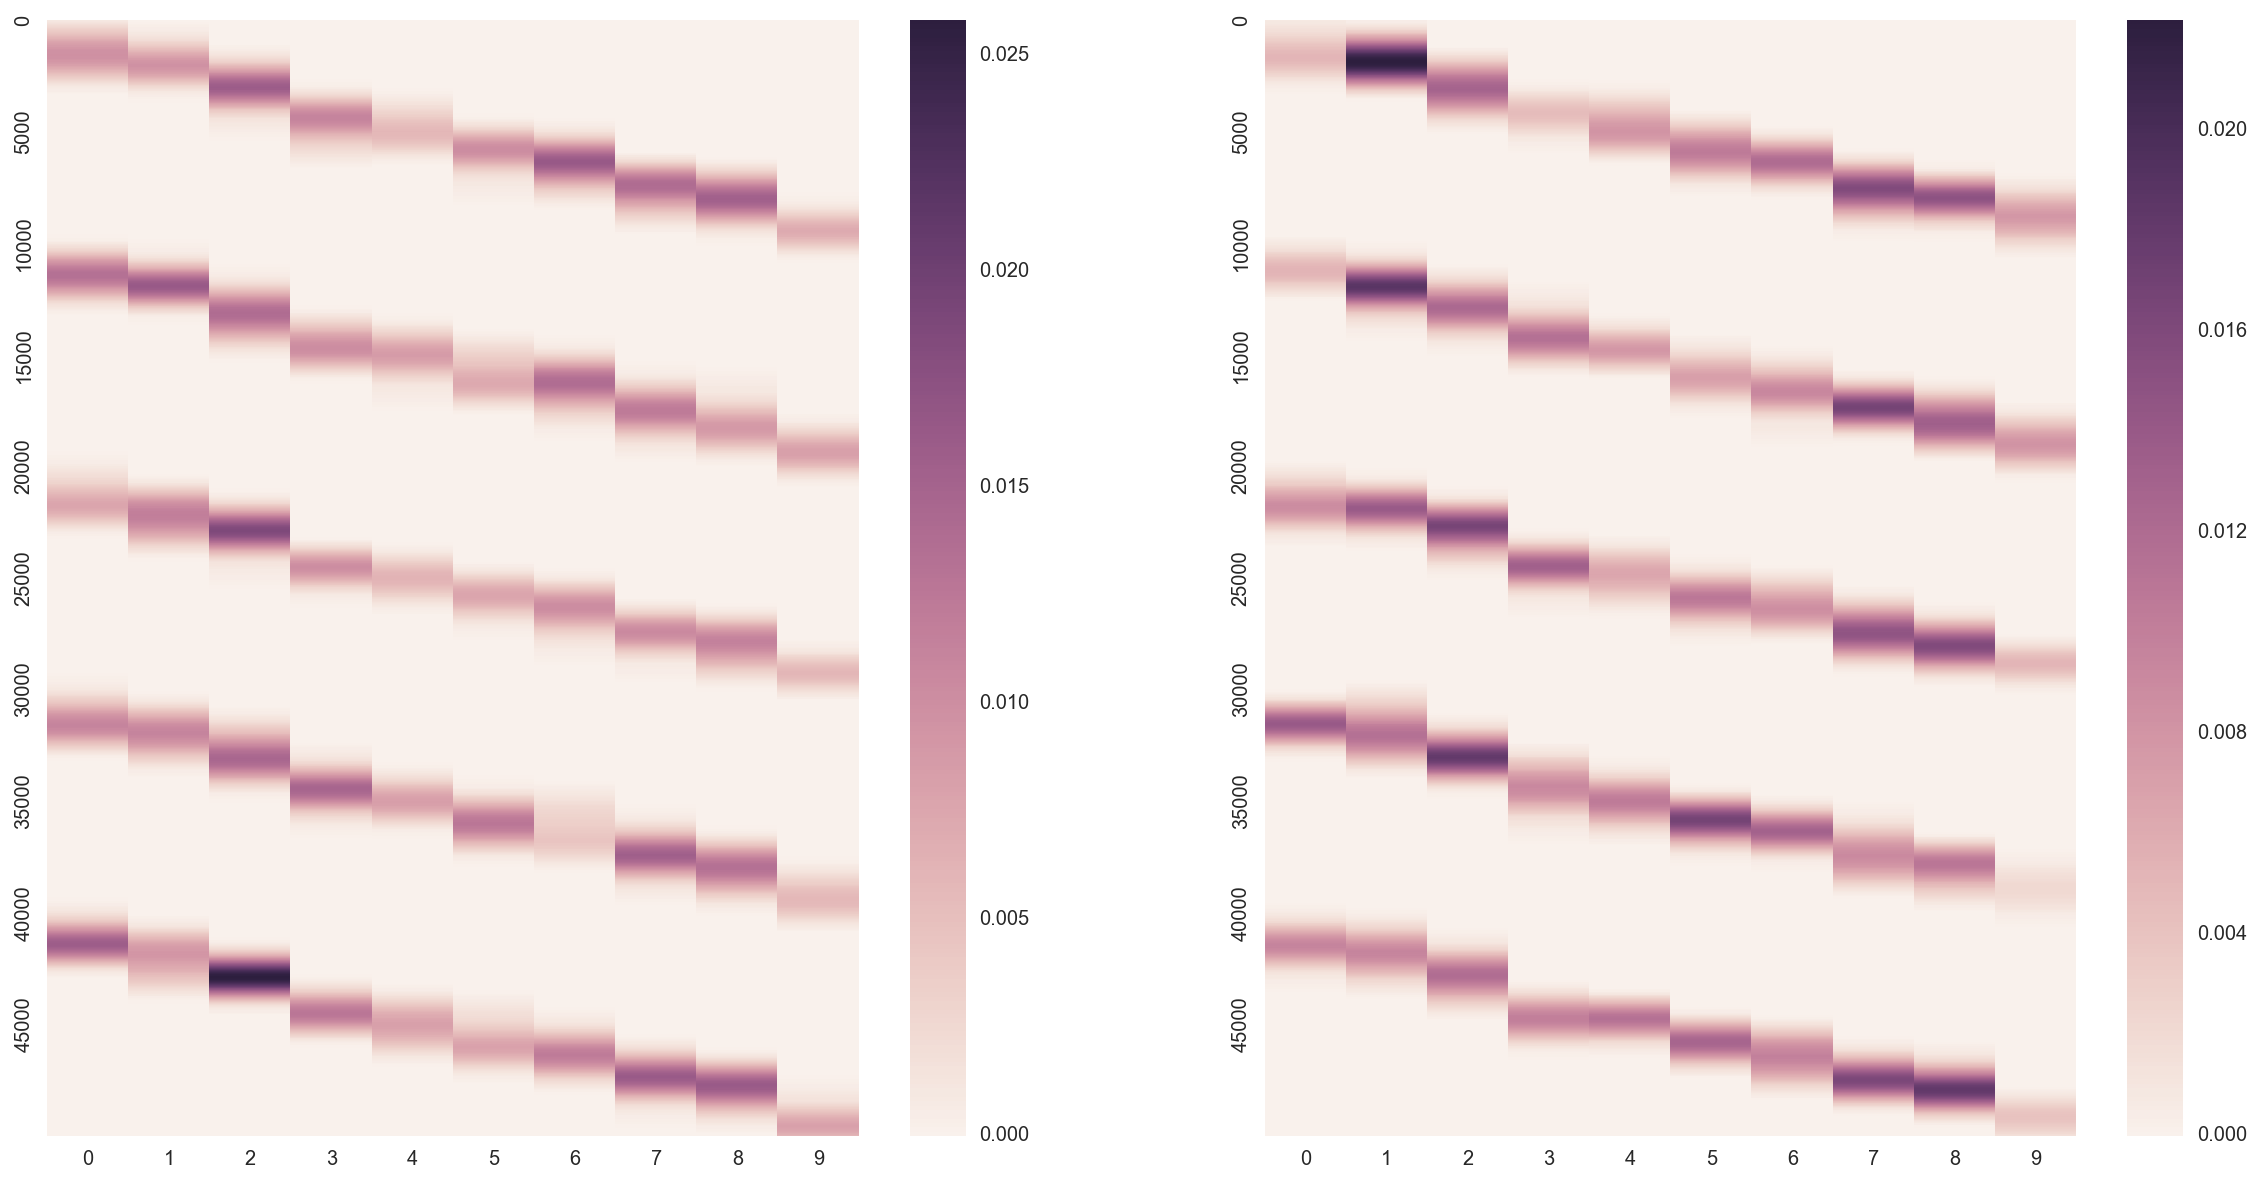

In [5]:
# do some plotting
f, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
_ = sns.heatmap(Q1,ax=ax1,yticklabels=len(Q1)//10)
_ = sns.heatmap(Q2,ax=ax2,yticklabels=len(Q2)//10)
plt.show()

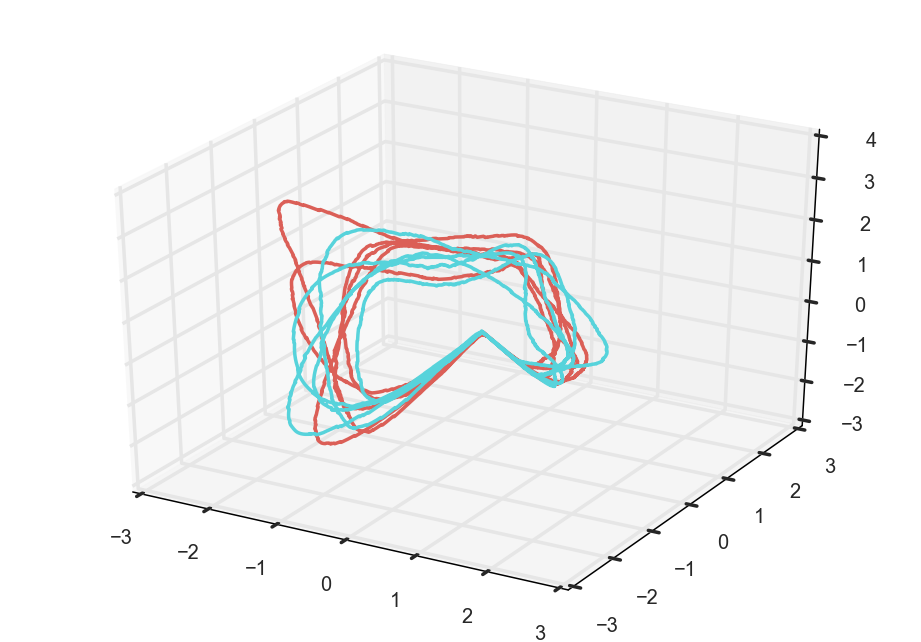

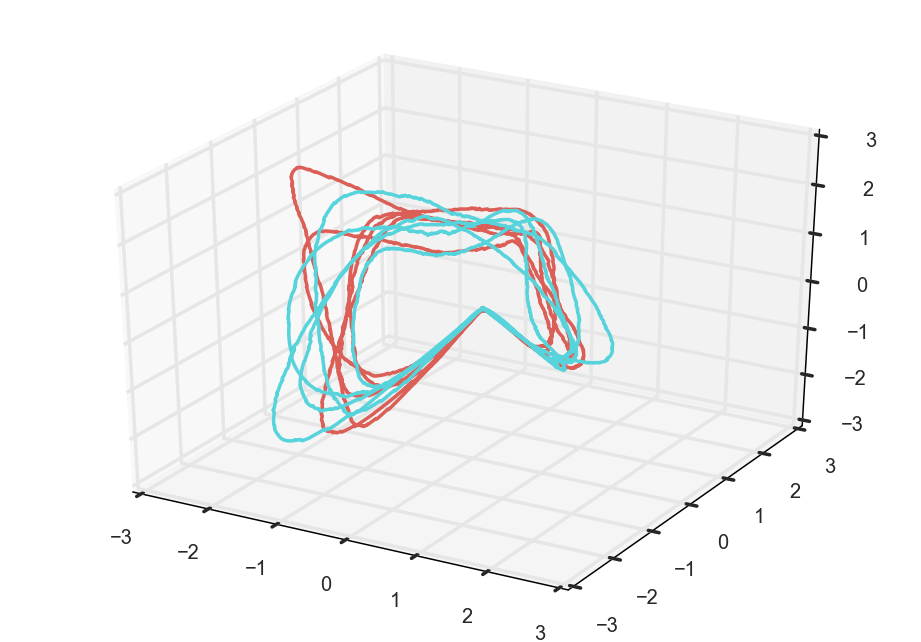

In [6]:
hyp.plot([Q1,Q2])
hyp.plot([hyp.tools.procrustes(Q1, Q2), Q2])